In [1]:
%load_ext autoreload
%autoreload 2

The cubelets dataset should be alright:

The xs corresponds now to the gephysical properties for the CVAE 
The xd corresponds to the forcing for the Surrogate
The y corresponds to the target for the Surrogate

In addition it may be useful to have also the climatology, therefore time varying inputs for the CVAE, but this is not a priority as I want to focus on static and at most temporal statistics layers

If I am going to use the SURROGATE 1D LSTM (find a better name for it) then I need to reshape the "xd" and "y" into NTC, which is ok with the cubeletsdataset, but may be slow for big datasets. For huge dataset we may need
either distributed computing. 

Reshaping of the CVAE output to match SURROGATE static inputs will occur in the model or training 

I don't think it I can use two dataloaders, one for CVAE and SURROGATE. 

The problem would be with randomization, in few words: one batch for the CVAE problem is essentially a 2D tile, composed by N pixels. I can randomly sample the batches (i.e. tiles) which is ok for training the CVAE, but for the 
SURROGATE I am constrained to randomly pick only the pixels within one tile.

Also in order to choose the batch size of the dataloader I need to consider how a N mini-batch of (H W) tiles becomes N*H*W for the SURROGATE, therefore I am kind of constrained in deciding the tile H W size 

Unless I can use one dataloader that provides the datasets and then loop over 



INPUT AND MODEL GRID ALIGNEMENT

There will be misalignement, meaning some of the input cells will fall partially under the model grid cell. 

But let's say I have 1000x1000 input, and one batch is 4x4 as I know that 4 cells of input are equivalent roughly to 1 cell of model .

Now the models overlaps the input, but each cell is 16 times bigger, so the cells are 250x250


In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [206]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import glob
from openeo.local import LocalConnection 
from hython.datasets.datasets import CubeletsDataset, TilesDataset
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray

In [5]:
conn = LocalConnection("./")

In [145]:
bounds = gpd.read_file("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticgeoms/basins.geojson").bounds.to_dict()
bounds

{'minx': {0: 10.28375},
 'miny': {0: 45.437083333333334},
 'maxx': {0: 12.327083333333334},
 'maxy': {0: 47.092083333333335}}

In [ ]:
bounds  = {b:bounds[i][0] for i,b in zip(bounds, ["west","south","east","north"])}

In [164]:
static = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticmaps.nc")

(180, 223)

In [6]:
bands =  ["bd_sl1","bd_sl2","bd_sl3", "bd_sl4", "bd_sl5", "bd_sl6",
    "clyppt_sl1","clyppt_sl2","clyppt_sl3", "clyppt_sl4", "clyppt_sl5", "clyppt_sl6",
    "sltppt_sl1","sltppt_sl2","sltppt_sl3", "sltppt_sl4", "sltppt_sl5", "sltppt_sl6",
    "sndppt_sl1","sndppt_sl2","sndppt_sl3", "sndppt_sl4", "sndppt_sl5", "sndppt_sl6",
    "ph_sl1","ph_sl2","ph_sl3", "ph_sl4", "ph_sl5", "ph_sl6",
    "oc_sl1","oc_sl2","oc_sl3", "oc_sl4", "oc_sl5", "oc_sl6",
    "soilthickness"]

In [148]:
das = [ conn.load_stac(url="https://stac.eurac.edu/collections/SOILGRIDS", bands = [band], spatial_extent=bounds).execute().to_dataset(dim="band").isel(time=0) for band in bands ]
ds = xr.merge(das, compat="override")

In [149]:
ds = ds.rename({"y":"lat", "x":"lon"})

In [150]:
XSIZE,YSIZE, TSIZE = 5, 5, 60
XOVER,YOVER,TOVER = 0, 0, 30

In [ ]:
mask = ds.bd_sl1.isnull().compute()
mask.plot()

In [223]:
ds.clyppt_sl1.sel(lat=slice(46.6,46.5), lon=slice(11,11.15)).shape,static.thetaR.sel(latitude=slice(46.6,46.5), longitude=slice(11,11.15)).shape

((48, 72), (11, 16))

In [ ]:
plt.figure(figsize=(14,8))
ds.clyppt_sl1.sel(lat=slice(46.6,46.5), lon=slice(11,11.15)).plot(cmap="Greys")
static.thetaR.sel(latitude=slice(46.6,46.5), longitude=slice(11,11.15)).plot(add_colorbar=False,alpha=0.6)

In [219]:
model_para, inp_data = xr.align(static.thetaR, ds.clyppt_sl1, )

# inp_data = inp_data.rio.set_crs(model_para.rio.crs)
# inp_data = inp_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat")

In [220]:
#inp_data2 = inp_data.rio.reproject_match(model_para)

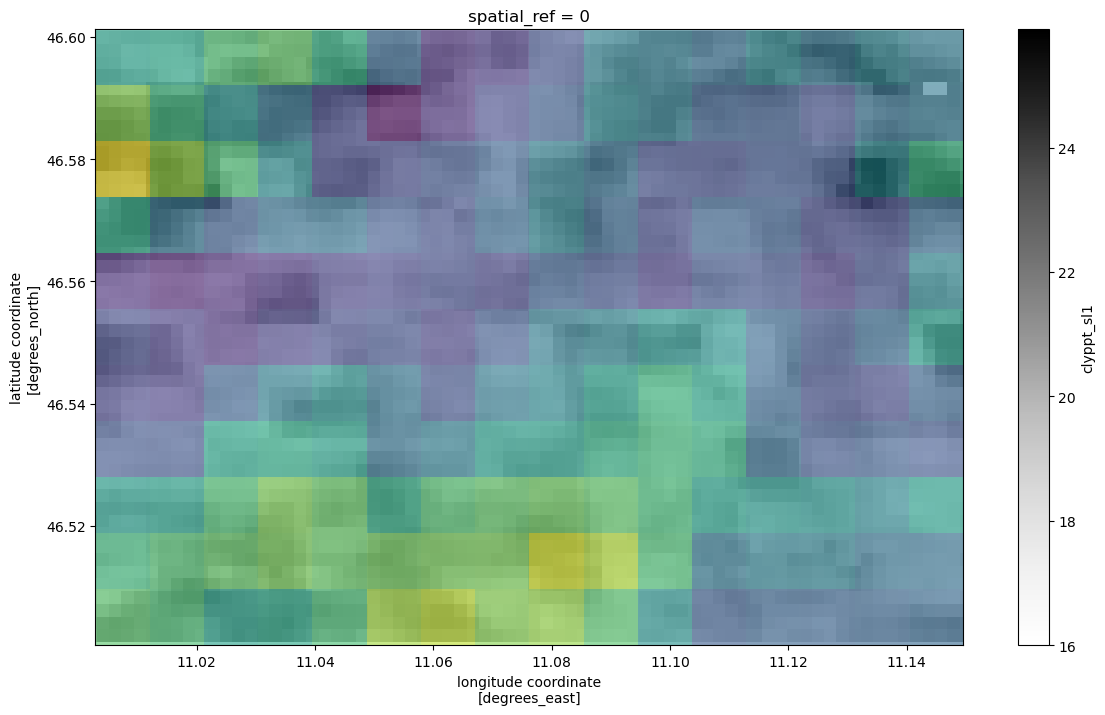

In [221]:
plt.figure(figsize=(14,8))
inp_data.sel(lat=slice(46.6,46.5), lon=slice(11,11.15)).plot(cmap="Greys")
model_para.sel(latitude=slice(46.6,46.5), longitude=slice(11,11.15)).plot(add_colorbar=False,alpha=0.6)

In [11]:
train_dataset = TilesDataset(xs = ds, 
            batch_size={"xsize":XSIZE,"ysize":YSIZE}, 
            overlap={"xover":XOVER, "yover":YOVER},
            shape = ds.bd_sl1.shape,
            mask = mask,
            
            persist=False)

In [152]:
test_dataset = TilesDataset(xs = ds.soilthickness.to_dataset(name="soilthickness"), 
            batch_size={"xsize":XSIZE,"ysize":YSIZE}, 
            overlap={"xover":XOVER, "yover":YOVER},
            shape = ds.bd_sl1.shape,
            mask = mask,
            persist=False)

In [ ]:
len(test_dataset)

In [ ]:
plt.imshow(test_dataset[2][0])

In [162]:
ds.soilthickness.shape, 

((795, 981), 1)

In [224]:
## TODO: pooling layers or strides for hierarchical learning

## TODO: soft constraints PTF

## TODO: Disjoin spatial subset for training and testing

## TODO: How to join with surrogate?

## TODO: Can I build a custom pooling operator instead of maxpooling?

In [155]:
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

class MaxPool2d(torch.nn.Module):

    def __init__(self, kernel_size=3, stride=1, padding=0):
        super(MaxPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)
        self.fc = nn.Linear(kernel_size*kernel_size,kernel_size*kernel_size)
    
    def forward(self, x):
        x = F.pad(x, self.padding, mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,))
        print(x.shape)
        pool, indices = torch.max(x, dim=-1)
        return pool.squeeze(-1)

In [122]:
test_dataset[400].unfold(2,5,2).shape

torch.Size([1, 100, 48, 5])

In [119]:
nn.MaxPool2d(5,1,2)(test_dataset[400]).shape

torch.Size([1, 100, 100])

In [92]:
print(test_dataset[400].shape)
_ = MaxPool2d(3,1,1)(test_dataset[400])
_.shape

torch.Size([1, 100, 100])
torch.Size([1, 102, 100, 1, 3])


torch.Size([1, 102, 100])

In [56]:
conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1)
pool1 = nn.AdaptiveAvgPool2d((10,12))
#pool1 = nn.AvgPool2d(kernel_size=3) #, padding=1)

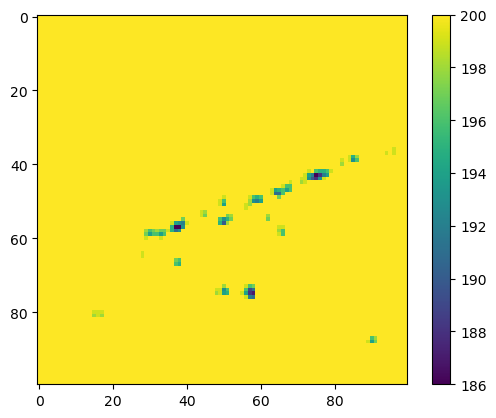

In [57]:
plt.imshow(test_dataset[400][0])
plt.colorbar()

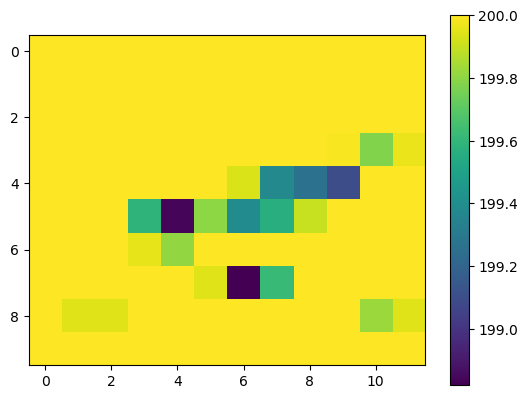

In [125]:
plt.imshow(pool1(test_dataset[400])[0].detach().numpy())
plt.colorbar()

In [88]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(len(bands), 64, kernel_size=3, stride=5, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=5, padding=1)
        self.fc1 = nn.Linear(128, 20)
        self.fc21 = nn.Linear(20, 1)  # mu layer
        self.fc22 = nn.Linear(20, 1)  # logvariance layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 128)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

In [92]:
encoder = Encoder()

In [123]:
class Surrogate(nn.Module):
    def __init__(self):
        pass
    def forward(self,xd):
        return xd

In [124]:
model = Surrogate()

In [80]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 7*7*256)
        self.conv2t = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, output_padding=1)
        self.conv3t = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, output_padding=1)
        self.conv4t = nn.ConvTranspose2d(64, len(bands), kernel_size=3, stride=1, padding=1, output_padding=1)

    def forward(self, z):
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)).view(-1, 256, 7, 7)
        x = F.relu(self.conv2t(x))
        x = F.relu(self.conv3t(x))
        return torch.sigmoid(self.conv4t(x))

In [57]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [58]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [59]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cvae = CVAE().to('cuda') if torch.cuda.is_available() else CVAE()
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

for epoch in range(10):
    for i, images in enumerate(train_loader):
        images = images.to('cuda') if torch.cuda.is_available() else images
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = cvae(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

RuntimeError: shape '[-1, 6272]' is invalid for input of size 1280000